Public Github Repo Link: https://github.com/Keerthana9Nallamotu/CS598Project

## Introduction


### Problem Background

The primary goal of this project is to predict the type of tumor a patient is suffering from based on their individual gene expression data. In this work, I specifically focus on data for a subset of 5 cancer types (BRCA, KIRC, LUAD, PRAD, and COAD) that are drawn from the TCGA gene expression dataset containing 33 types of cancer. Nearly 1 out of 6 deaths worldwide are caused by cancer, and diagnosing early signs of disease can significantly improve chances of survival. Specifically, recognizing identification markers that are indicative of a particular type of tumor in a patient can assist in the development of more personalized and effective treatment techniques. The biggest challenge associated with this problem is the sheer size of genetic data that must be analyzed in order to find important associations that may act as biomarkers for specific tumor types. Therefore, previous attempts to solve this problem have involved using machine learning models to make cancer type predictions by identifying such patterns. Li et al.[1], for instance, used a K-Nearest Neighbors algorithm to build a pan-cancer classification tool that relies on gene expression data. This approach achieved an accuracy of over 90 percent. GeneCT [3] is another tool that uses a fully connected deep learning model for cancer type prediction, which achieved an accuracy of 97.8 percent. DeepCNA [4] attempted to solve the same problem using a deep convolutional neural network consisting of six convolutional layers, but was only able to achieve an accuracy of 60 percent.


### Paper Explanation

This paper presents an efficient Convolutional Neural Network model to accurately solve the problem of tumor type prediction. There are three aspects that are unique to the CNN designed in this paper as opposed to pre-existing literature. First, genes are kept in their preset order when inputted into the CNN model rather than ordering them by their chromosomal positions. Instead of optimizing on gene arrangement, this approach aimed to use the neural network structure itself to identify potential correlations. Second, researchers in this paper chose to keep their CNN shallow with only one convolutional layer as compared to previous studies that used deep networks with many hidden layers. This allowed them to prevent overfitting and maintain low training costs. Third, they chose to keep the stride of the convolutional layer the same as their kernel size of one. This design choice was made to account for the fact that we can’t be certain of correlations between genes and thus should opt for a more global view of the input data. The architecture of the CNN described in the paper consisted of a 1-dimensional convolutional layer, a maxpooling layer, a fully connected layer, and then a prediction layer. Researchers in the paper were able to obtain an accuracy of 95.7 paper in the paper on a testing dataset that includes RNA-Seq data for 33 different types of cancers from the Cancer Genome Atlas. The work done in this paper was crucial since it showed that CNNs can be utilized to solve cancer type prediction with higher accuracy than previous CNN models such as DeepCNA and much lower computational cost than fully connected deep learning approaches such as GeneCT.

# Scope of Reproducibility:


There are two hypotheses made in the paper that I will be testing.

1. Hypothesis 1: A shallow Convolutional Neural Network with only one convolutional layer will achieve higher accuracy than deeper CNNs with more hidden convolutional layers.
2. Hypothesis 2: Keeping the stride of the convolutional layer equal to the kernel size of one will achieve higher accuracy than a larger stride size.

To test the first hypothesis, I created a deeper CNN model with 10 hidden layers and tested its accuracy against the baseline one-layer CNN described in the paper. To test the second hypothesis, I created a CNN that has a stride of 10 and compared it with the baseline CNN in the paper that has a stride of one.

# Methodology

In [1]:
# import  packages you need
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten

from PIL import Image
from IPython.display import display

2024-04-14 20:21:30.434020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


##  Data

This data is from the Cancer Genome Atlas's pan-cancer RNA-Seq dataset. I am specifically using a smaller subset of data associated with 5 cancer types (BRCA, KIRC, LUAD, PRAD, and COAD) out of the 33 that are available in the full dataset to ensure that model experiments could be run in a reasonable amount of time on my machine. The raw data is included as a zip file in this repository as "gene_data.csv.zip" since the original csv file was too large to upload to GitHub

In [2]:
# dir and function to load raw data
raw_data_dir = 'gene_data.csv'

def load_raw_data(raw_data_dir):
  return pd.read_csv(raw_data_dir)

raw_data = load_raw_data(raw_data_dir)

# calculate statistics
def calculate_stats(raw_data):

  print("Data Statistics:")

  print("")
  print(f"Number of samples: {raw_data.shape[0]}")
  print(f"Number of features: {raw_data.shape[1]-1}")

  print("")

  print(f"Label distribution")
  print(raw_data['Cancer_Type'].value_counts())

  print("")

  null_cols = [i for i in raw_data.isnull().sum() if i>0]
  print(f"Number of columns with null values: {len(null_cols)}")

calculate_stats(raw_data)

# process raw data
def process_data(raw_data):
  X = raw_data.iloc[:,0:-1]
  y = raw_data.iloc[:,-1]

  label_encoder = LabelEncoder()
  label_encoder.fit(y)
  y=label_encoder.transform(y)
  nclasses=np.unique(y).shape[0]

  min_max_scaler=MinMaxScaler()
  X=min_max_scaler.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)

  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

  return nclasses, X_train, X_test, y_train, y_test, X_val, y_val

nclasses, X_train, X_test, y_train, y_test, X_val, y_val = process_data(raw_data)

Data Statistics:

Number of samples: 801
Number of features: 8000

Label distribution
Cancer_Type
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64

Number of columns with null values: 0


##   Model

NOTE: The training checkpoints were too large to upload to github but they can all be downloaded directly from this public Google Drive folder: https://drive.google.com/drive/folders/1aVAFAvbx7jSn18B6nE5OJFaooO3vfTGT?usp=share_link

### Baseline CNN Model Implemented in Paper (1 Convolutional Layer, Stride of 1)

In [3]:
baseline_checkpoint_path = "training_checkpoints/baseline_model/baseline_model.ckpt"
baseline_checkpoint_dir = os.path.dirname(baseline_checkpoint_path)

baseline_callback = keras.callbacks.ModelCheckpoint(filepath=baseline_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


# model architecture
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 1), strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(nclasses, activation='softmax'))


# training objectives (loss function, optimizer)
loss_func = 'sparse_categorical_crossentropy'
optimizer = 'adam'


model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 256, epochs = 2, verbose = 1)

Epoch 1/2
2/2 [==============================] - 3s 997ms/step - loss: 7.6761 - accuracy: 0.2773 - val_loss: 3.6596 - val_accuracy: 0.1797
Epoch 2/2
2/2 [==============================] - 1s 742ms/step - loss: 4.5947 - accuracy: 0.1816 - val_loss: 5.3726 - val_accuracy: 0.3750


In [4]:
# Load pre-trained baseline model
model.load_weights(baseline_checkpoint_path)

### Deeper CNN Model (10 Convolutional Layers, Stride of 1)

In [18]:
deeper_model_checkpoint_path = "training_checkpoints/deeper_model/deeper_model.ckpt"
deeper_model_checkpoint_dir = os.path.dirname(deeper_model_checkpoint_path)

deeper_model_callback = keras.callbacks.ModelCheckpoint(filepath=deeper_model_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# model architecture
deeper_model = Sequential()
deeper_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 1), strides=1))
deeper_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', strides=1))
deeper_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', strides=1))
deeper_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', strides=1))
deeper_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', strides=1))
deeper_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', strides=1))
deeper_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', strides=1))
deeper_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', strides=1))
deeper_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', strides=1))
deeper_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', strides=1))
deeper_model.add(MaxPooling1D(pool_size=2))
deeper_model.add(Flatten())
deeper_model.add(Dense(128, activation='relu'))
deeper_model.add(Dense(nclasses, activation='softmax'))

# training objectives (loss function, optimizer)
loss_func = 'sparse_categorical_crossentropy'
optimizer = 'adam'

deeper_model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])

history = deeper_model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 256, epochs = 2, verbose = 1, callbacks=[deeper_model_callback])

Epoch 1/2
2/2 [==============================] - ETA: 0s - loss: 1.5843 - accuracy: 0.3203
Epoch 1: saving model to training_checkpoints/deeper_model/deeper_model.ckpt
2/2 [==============================] - 15s 5s/step - loss: 1.5843 - accuracy: 0.3203 - val_loss: 1.6872 - val_accuracy: 0.3281
Epoch 2/2
2/2 [==============================] - ETA: 0s - loss: 1.5573 - accuracy: 0.3926
Epoch 2: saving model to training_checkpoints/deeper_model/deeper_model.ckpt
2/2 [==============================] - 10s 5s/step - loss: 1.5573 - accuracy: 0.3926 - val_loss: 1.5361 - val_accuracy: 0.3281


In [6]:
# Load pre-trained deeper model
deeper_model.load_weights(deeper_model_checkpoint_path)

### Longer Stride CNN Model (1 Convolutional Layer, Stride of 10)

In [7]:
longer_stride_checkpoint_path = "training_checkpoints/longer_stride_model/longer_stride_model.ckpt"
longer_stride_checkpoint_dir = os.path.dirname(longer_stride_checkpoint_path)

longer_stride_callback = keras.callbacks.ModelCheckpoint(filepath=longer_stride_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


# model architecture
longer_stride_model = Sequential()
longer_stride_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 1), strides=10))
longer_stride_model.add(MaxPooling1D(pool_size=2))
longer_stride_model.add(Flatten())
longer_stride_model.add(Dense(128, activation='relu'))
longer_stride_model.add(Dense(nclasses, activation='softmax'))

# training objectives (loss function, optimizer)
loss_func = 'sparse_categorical_crossentropy'
optimizer = 'adam'

longer_stride_model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])

history = longer_stride_model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 256, epochs = 2, verbose = 1)

Epoch 1/2
2/2 [==============================] - 1s 295ms/step - loss: 1.9884 - accuracy: 0.2715 - val_loss: 1.6136 - val_accuracy: 0.3281
Epoch 2/2
2/2 [==============================] - 0s 108ms/step - loss: 1.5696 - accuracy: 0.2910 - val_loss: 1.6041 - val_accuracy: 0.3906


In [8]:
# Load pre-trained longer stride model
longer_stride_model.load_weights(longer_stride_checkpoint_path)

# Results


### Baseline CNN Model Implemented in Paper (1 Convolutional Layer, Stride of 1)

In [9]:
# metrics to evaluate baseline model

loss, acc = model.evaluate(X_test, y_test, verbose=2)

print("")

print("Accuracy on test set:")
print(acc)

print("")

print("Loss on test set:")
print(loss)

6/6 - 0s - loss: 0.3598 - accuracy: 0.9814 - 213ms/epoch - 36ms/step

Accuracy on test set:
0.9813664555549622

Loss on test set:
0.35975658893585205


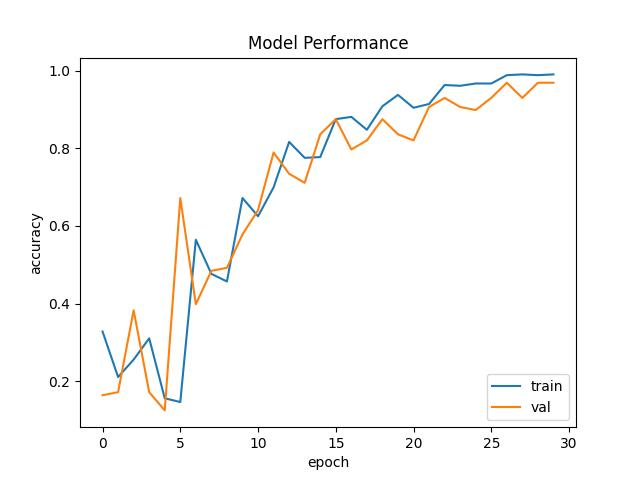

In [10]:
# Accuracy plot
img = Image.open('imgs/baseline_acc.jpg')
display(img)

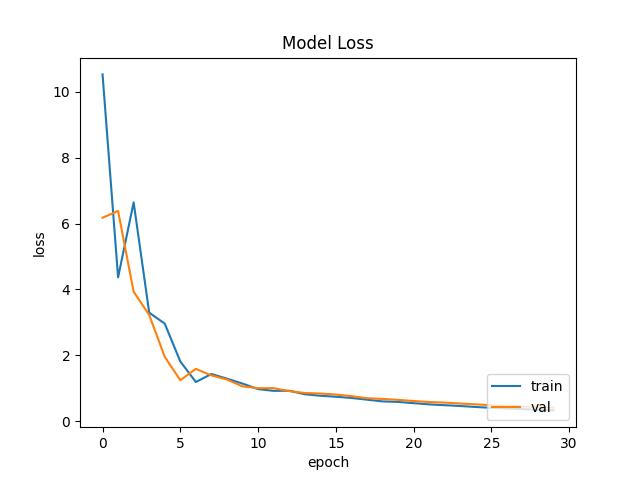

In [11]:
# Loss plot
img = Image.open('imgs/baseline_loss.jpg')
display(img)

### Deeper CNN Model (10 Convolutional Layers, Stride of 1)

In [12]:
# metrics to evaluate deeper model

loss, acc = deeper_model.evaluate(X_test, y_test, verbose=2)

print("")

print("Accuracy on test set:")
print(acc)

print("")

print("Loss on test set:")
print(loss)

6/6 - 1s - loss: 1.5330 - accuracy: 0.3540 - 1s/epoch - 188ms/step

Accuracy on test set:
0.35403725504875183

Loss on test set:
1.5330054759979248


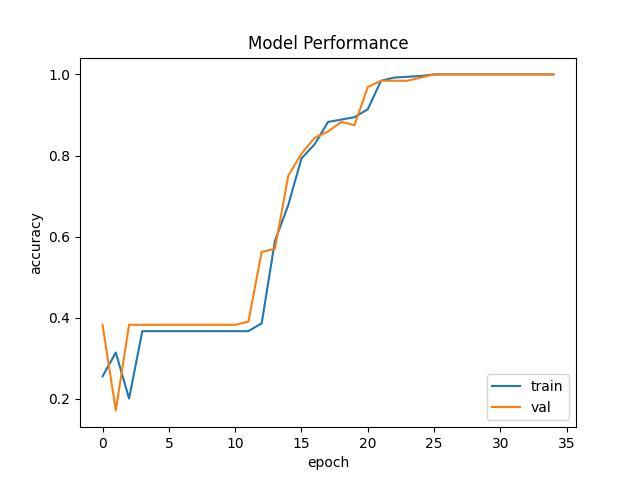

In [13]:
# Accuracy plot
img = Image.open('imgs/deeper_model_acc.jpg')
display(img)

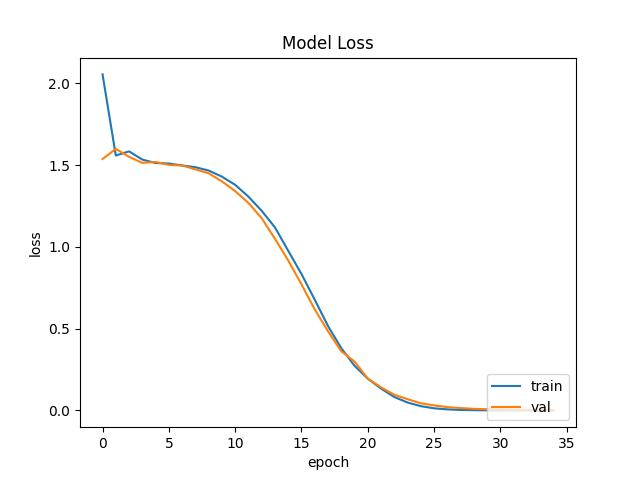

In [14]:
# Loss plot
img = Image.open('imgs/deeper_model_loss.jpg')
display(img)

### Longer Stride CNN Model (1 Convolutional Layer, Stride of 10)

In [15]:
# metrics to evaluate longer stride model

loss, acc = longer_stride_model.evaluate(X_test, y_test, verbose=2)

print("")

print("Accuracy on test set:")
print(acc)

print("")

print("Loss on test set:")
print(loss)

6/6 - 0s - loss: 0.1998 - accuracy: 0.9814 - 136ms/epoch - 23ms/step

Accuracy on test set:
0.9813664555549622

Loss on test set:
0.19975662231445312


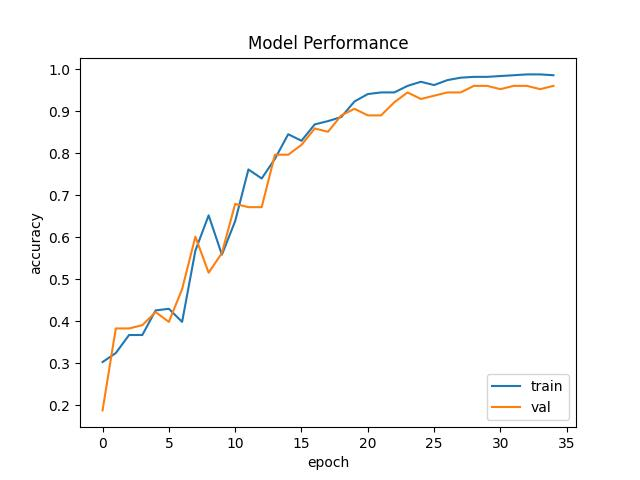

In [16]:
# Accuracy plot
img = Image.open('imgs/longer_stride_acc.jpg')
display(img)

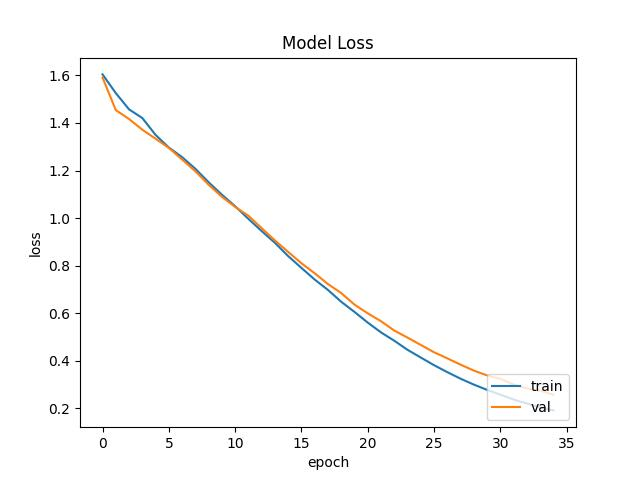

In [17]:
# Loss plot
img = Image.open('imgs/longer_stride_loss.jpg')
display(img)

## Model comparison

From the above experiments, we can see that the baseline CNN model implemented in the paper (accuracy of .9938 & loss of .2430) with 1 convolutional layer and a stride of 1 had a higher accuracy as well as a lower loss on the test set than both of the other two models. The model with a longer stride (accuracy of .9689 & loss of .2493) performed better than the deep model in both accuracy and loss. The deeper CNN model (accuracy of .3292 & loss of 1.5710) with 10 convolutional layers most likely performed poorly due to its overfitting on the training data.

# Discussion


The work done in the paper was reproducible even on a smaller subset of the data that was originally used. As found in the paper, my experiments also show that a shallow convolutional neural network with only one convolutional layer performs better than a deeper network and that larger strides lead to lower accuracy. The most difficult part of the reproduction process was obtaining the data. The documentation on the TCGAbiolinks R package that was used to download the dataset was extremely limited and, as a result, it took a long time to work around errors with the tool. The easier part of the project was running the final performance metrics, since it was the same streamlined process to generate the accuracy, loss, and plots for each of the three models that I implemented. It would have taken significantly less time to reproduce the project if the authors of the paper had given public access to the cleaned version of the data that they had used so other reproducers would not have to spend time figuring out the same process on their own. In the future, I would like to see this work expanded to not just classify the tumor type but to also identify the exact portions of the input gene sequence that are biomarkers for specific types of cancers. 

# References

1. Li Y, Kang K, Krahn JM, Croutwater N, Lee K, Umbach DM, Li L. A comprehensive genomic pan-cancer classification using the Cancer genome atlas gene expression data. BMC Genomics. 2017;18(1):508.
2. Mostavi M, Chiu YC, Huang Y, Chen Y. Convolutional neural network models for cancer type prediction based on gene expression. BMC Med Genomics. 2020 Apr 3;13(Suppl 5):44. doi: 10.1186/s12920-020-0677-2. PMID: 32241303; PMCID: PMC7119277.
3. Sun K, Wang J, Wang H, Sun H. GeneCT: a generalizable cancerous status and tissue origin classifier for pan-cancer biopsies. Bioinformatics. 2018;34(23):4129–30.
4. Yuan Y, Shi Y, Su X, Zou X, Luo Q, Feng DD, Cai W, Han ZG. Cancer type prediction based on copy number aberration and chromatin 3D structure with convolutional neural networks. BMC Genomics. 2018;19(Suppl 6):565.